# 09wk-2: 중간고사

최규빈  
2024-05-01

In [1]:
import torch 
import torchvision
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import PIL

import requests
import io

# `1`. 크롤링을 통한 이미지 분석 및 CAM – 30점

`(1)` 두 가지 키워드로 크롤링을 수행하여 이미지자료를 모아라. (키워드는
각자 마음에 드는 것으로 설정할 것) – 01wk-1 의 HW를 그대로 활용해도 무방

In [7]:
train_dataset = torchvision.datasets.OxfordIIITPet(
    root='/root/DL2025/data', 
    split='trainval',
    download=True,
    target_types='binary-category'
)
test_dataset = torchvision.datasets.OxfordIIITPet(
    root='/root/DL2025/data', 
    split='test',
    download=True,
    target_types='binary-category' ## binary
)

In [8]:
compose = torchvision.transforms.Compose([
    torchvision.transforms.Resize((512, 512)), ## 이미지 사이즈 통일
    torchvision.transforms.ToTensor() ## 이미지를 텐서로 변환
])

X = torch.stack([compose(train_dataset[i][0]) for i in range(len(train_dataset))], axis = 0)
XX = torch.stack([compose(test_dataset[i][0]) for i in range(len(test_dataset))], axis = 0)

y = torch.tensor([train_dataset[i][1] for i in range(len(train_dataset))]).reshape(-1, 1).float()
yy = torch.tensor([test_dataset[i][1] for i in range(len(test_dataset))]).reshape(-1, 1).float()

`(2)` ImageDataLoaders.from_folder 를 이용하여 dls를 만들어라.

`(3)` resnet34를 이용하여 학습하라.

In [10]:
## step 1 : 데이터 로드
ds_train = torch.utils.data.TensorDataset(X, y)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size = 32, shuffle = True)

ds_test = torch.utils.data.TensorDataset(XX, yy)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size = 32)


## step 2 : 모델 및 가중치 불러오기
resnet34 = torchvision.models.resnet34(pretrained = True) ## 18이랑 뒤는 똑같네
resnet34.fc = torch.nn.Linear(512, 1)

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(resnet34.parameters(), lr = 1e-5) ## 세부조정만


## step 3 : 사후 트레이닝
resnet34.to("cuda:0")

for epoc in range(3) :
    resnet34.train() ## dropout 있음

    for Xm, ym in dl_train :
        Xm = Xm.to("cuda:0")
        ym = ym.to("cuda:0")

        netout = resnet34(Xm)
        
        loss = loss_fn(netout, ym)
        loss.backward()

        optimizr.step()
        optimizr.zero_grad()

    ## eval in epochs
    resnet34.eval()
    s = 0
    
    for Xm, ym in dl_train :
        Xm = Xm.to("cuda:0")
        ym = ym.to("cuda:0")

        s += ((resnet34(Xm) > 0.0) == ym).sum().item()

    train_acc = s/len(X)

    print(f"epoch : {epoc},\ttrain_acc = {train_acc:.4f}")


## step 4 : 평가
# resnet34.eval() ## 이미 평가모드임
s = 0

for XXm, yym in dl_test :
    XXm = XXm.to("cuda:0")
    yym = yym.to("cuda:0")

    s += ((resnet34(XXm) > 0.0) == yym).sum().item()

test_acc = s/len(XX)

print(f"test_acc = {test_acc:.4f}")

/root/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch : 0,	train_acc = 0.9989
epoch : 1,	train_acc = 1.0000
epoch : 2,	train_acc = 1.0000
test_acc = 0.9984


`(4)` CAM (class activation mapping)을 이용하여 (3)의 모형의 판단근거를
시각화하라.

In [14]:
stem = torch.nn.Sequential(
    ## layer 0
    torch.nn.Sequential(
        resnet34.conv1,
        resnet34.bn1,
        resnet34.relu,
        resnet34.maxpool
    ),

    resnet34.layer1,
    resnet34.layer2,
    resnet34.layer3,
    resnet34.layer4
)

head = torch.nn.Sequential(
    resnet34.avgpool,
    torch.nn.Flatten(),
    resnet34.fc
)

net = torch.nn.Sequential(
    stem,
    head
)

ap = head[0]
flattn = head[1]
linr = head[2]

def _linr(X) :
    return torch.einsum("ochw, kc -> okhw", X, linr.weight.data) + linr.bias.data

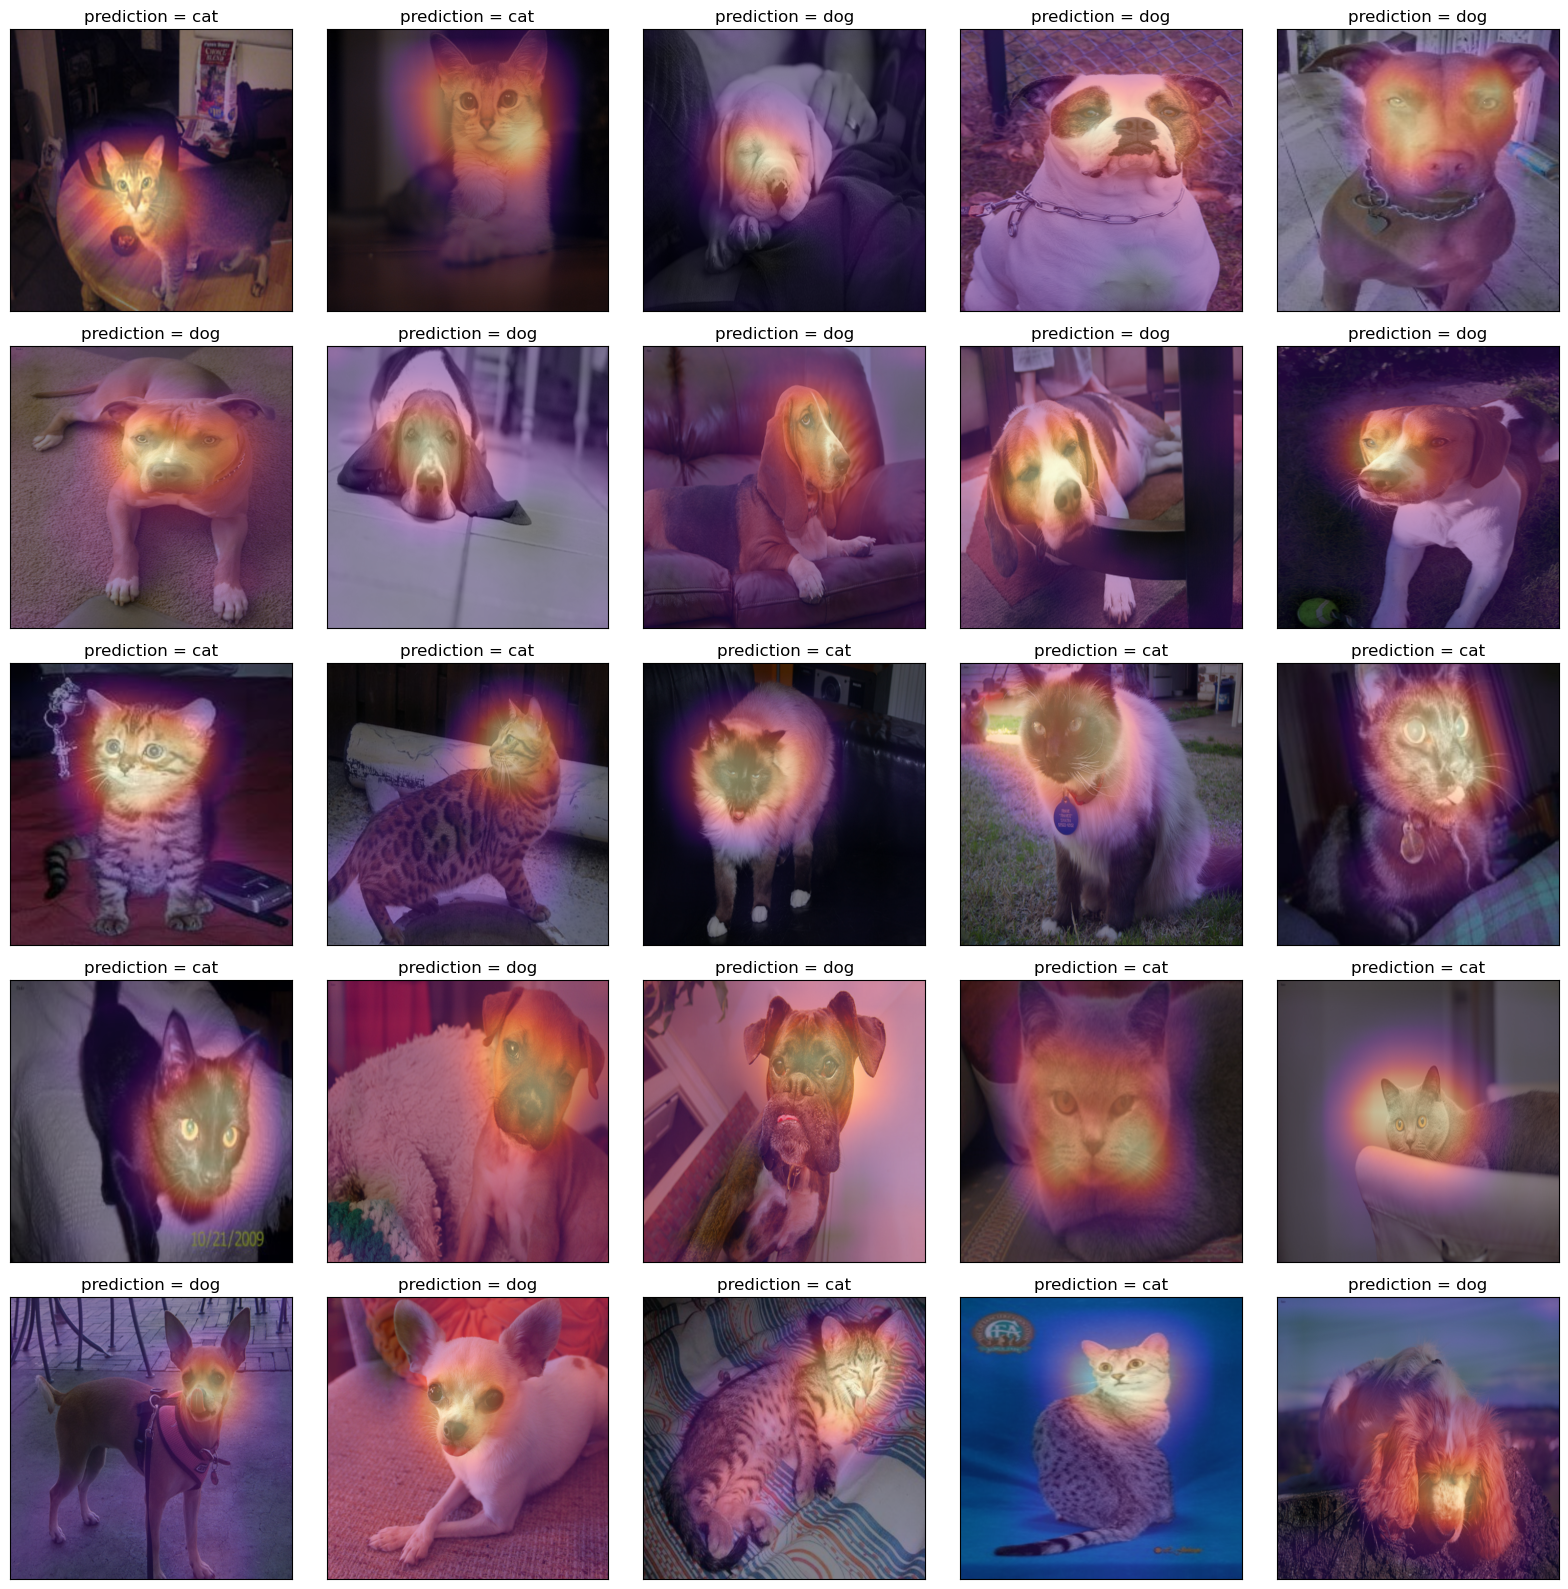

In [15]:
fig, ax = plt.subplots(5, 5)

#---#
k = 0

for i in range(5) :
    for j in range(5) :
        ##--------핵심 코드--------##
        
        x = XX[[k]].to("cuda:0")
        
        if net(x) > 0 :
            pred = "dog"
            why = _linr(stem(x))
        
        else :
            pred = "cat"
            why = - _linr(stem(x))

        ## 보간법으로 이미지 크기 조정
        why_resized = torch.nn.functional.interpolate(
            why, size = (512, 512), mode = "bilinear"
        ) ## (1, 1, 512, 512)로 나옴

        ax[i][j].imshow(x.squeeze().cpu().data.permute(1, 2, 0))
        ax[i][j].imshow(why_resized.squeeze().cpu().data, cmap = "magma", alpha = 0.5)
        
        ##--------핵심 코드--------##

        
        ax[i][j].set_title(f"prediction = {pred}")
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

        k += 50

fig.set_figheight(16)
fig.set_figwidth(16)
fig.tight_layout()

In [16]:
torch.cuda.empty_cache()

# `2`. 생성모형 / GAN – 40점

아래는 `torchvision`을 활용하여 MNIST 데이터를 불러오고 `DataLoader`를
생성하는 코드이다.

In [3]:
# Data preprocessing
ds = dataset = torchvision.datasets.MNIST(
    root = '/root/DL2025/data/',
    download=True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(64), # 이미지를 (64,64)로 resize 
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,))
    ])
)
# Dataloader
dl = torch.utils.data.DataLoader(
    ds, 
    batch_size=120,
    shuffle=True, 
)

`(1)` `iter`와 `next`를 이용하여 데이터로더의 첫번째 배치를 출력하라.
하나의 배치에 몇개의 이미지가 있는가? 이미지는 흑백인가 칼라인가?
이미지의 크기는 얼마인가?

In [4]:
## 첫 번째 배치
print(f"첫 번째 배치 : {next(iter(dl))}")

첫 번째 배치 : [tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
     

In [5]:
next(iter(dl))[0].shape

torch.Size([120, 1, 64, 64])

> 하나의 배치에는 120개의 64x64 픽셀 흑백 이미지가 들어있다.

`(2)` 아래의 함수를 이용하여 하나의 배치에 포함된 이미지를 출력하라.

In [6]:
def imshow(xi_real):
    plt.imshow(torch.einsum('cij->ijc',torchvision.utils.make_grid(xi_real, padding=2, normalize=True)))

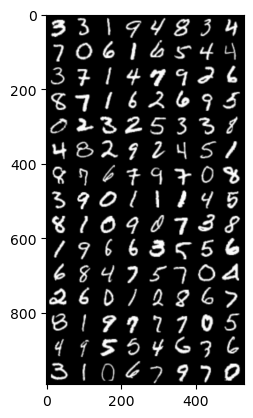

In [7]:
imshow(next(iter(dl))[0])

`(3)` 아래의 코드를 이용하여 `net_police`를 생성하라.

In [8]:
net_police = torch.nn.Sequential(
    # Layer1
    torch.nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.LeakyReLU(0.2),
    # Layer2
    torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(128),
    torch.nn.LeakyReLU(0.2),
    # Layer3
    torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(256),
    torch.nn.LeakyReLU(0.2),
    # Layer4
    torch.nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(512),
    torch.nn.LeakyReLU(0.2),
    # Layer5
    torch.nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    torch.nn.Sigmoid(),
    torch.nn.Flatten()
)

`net_police`에 하나의 배치를 넣어보고 각 층별 출력크기를 조사하라.

In [9]:
print(f"layer 1 : {net_police[:2](next(iter(dl))[0]).shape}")
print(f"layer 2 : {net_police[:5](next(iter(dl))[0]).shape}")
print(f"layer 3 : {net_police[:8](next(iter(dl))[0]).shape}")
print(f"layer 4 : {net_police[:11](next(iter(dl))[0]).shape}")
print(f"layer 5 : {net_police(next(iter(dl))[0]).shape}")

layer 1 : torch.Size([120, 64, 32, 32])
layer 2 : torch.Size([120, 128, 16, 16])
layer 3 : torch.Size([120, 256, 8, 8])
layer 4 : torch.Size([120, 512, 4, 4])
layer 5 : torch.Size([120, 1])


`(4)` 아래의 코드를 이용하여 `net_faker`를 생성하라.

In [10]:
net_faker = torch.nn.Sequential(
    # Layer1
    torch.nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, padding=0, bias=False),
    torch.nn.BatchNorm2d(512),
    torch.nn.ReLU(),
    # Layer2
    torch.nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(256),
    torch.nn.ReLU(),
    # Layer3
    torch.nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(),
    # Layer4
    torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    # Layer5
    torch.nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.Tanh()
)

`net_faker`에 아래의 noise를 넣어보고 각 층별 출력크기를 조사하라.

``` python
ni = torch.randn(batch_size, 100, 1, 1)
```

In [11]:
batch_size = 120
ni = torch.randn(batch_size, 100, 1, 1)

print(f"layer 1 : {net_faker[:3](ni).shape}")
print(f"layer 2 : {net_faker[:6](ni).shape}")
print(f"layer 3 : {net_faker[:9](ni).shape}")
print(f"layer 4 : {net_faker[:12](ni).shape}")
print(f"layer 5 : {net_faker(ni).shape}")

layer 1 : torch.Size([120, 512, 4, 4])
layer 2 : torch.Size([120, 256, 8, 8])
layer 3 : torch.Size([120, 128, 16, 16])
layer 4 : torch.Size([120, 64, 32, 32])
layer 5 : torch.Size([120, 1, 64, 64])


`(5)` 아래와 같이 두개의 `optimizr` 를 선언하라.

In [12]:
optimizr_police = torch.optim.Adam(net_police.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizr_faker = torch.optim.Adam(net_faker.parameters(), lr=0.0002, betas=(0.5, 0.999))

아래의 세부지침에 맞추어 `net_police` 와 `net_faker`를 학습하라.

1.  5 Epoch을 진행하여 학습할 것
2.  GPU를 이용하여 학습할 것

In [13]:
net_police.to("cuda:0")
net_faker.to("cuda:0")

bce = torch.nn.BCELoss()

##---##
for epoc in range(5) :
    for Xm, _ in dl :
        ##--------police training 1 epoch--------##
        Xm_real = Xm.to("cuda:0")
        Xm_fake = net_faker(torch.randn(len(Xm_real), 100, 1, 1).to("cuda:0")).data
        
        ym_real = torch.tensor([0.0]*len(Xm_real)).reshape(-1, 1).to("cuda:0")
        ym_fake = torch.tensor([1.0]*len(Xm_real)).reshape(-1, 1).to("cuda:0")

        yhat_real = net_police(Xm_real)
        yhat_fake = net_police(Xm_fake)
        
        loss = bce(yhat_real, ym_real) + bce(yhat_fake, ym_fake) ## 경찰은 둘다 잘해야 함
        loss.backward()
    
        optimizr_police.step()
        optimizr_police.zero_grad()
    
        ##----------faker training 1 epoch--------##
        Xm_fake = net_faker(torch.randn(len(Xm_real), 100, 1, 1).to("cuda:0")) ## 네트워크의 output -> 미분필요
        ym_real = torch.tensor([0.0]*len(Xm_fake)).reshape(-1, 1).to("cuda:0")
        
        yhat_fake = net_police(Xm_fake)

        loss = bce(yhat_fake, ym_real) ## 식별자가 자신의 output을 반대로 식별해야 함
        loss.backward()
    
        optimizr_faker.step()
        optimizr_faker.zero_grad()

    print(f"epoch = {epoc+1}/5")

epoch = 1/5
epoch = 2/5
epoch = 3/5
epoch = 4/5
epoch = 5/5


`(6)` 학습결과를 (2)의 imshow 함수를 이용하여 시각화하라.

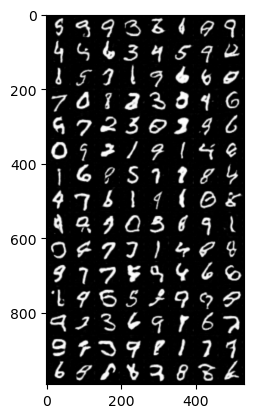

In [14]:
ni = torch.randn(120, 100, 1, 1).to("cuda:0")
imshow(net_faker(ni).data.to("cpu"))

# 3. 단순회귀문제 – 10점

주어진 자료가 아래와 같다고 하자.

In [3]:
torch.manual_seed(43052)
x,_ = torch.randn(100).sort()
x = x.reshape(-1,1)
ϵ = torch.randn(100).reshape(-1,1)*0.5
y = 2.5+ 4*x + ϵ

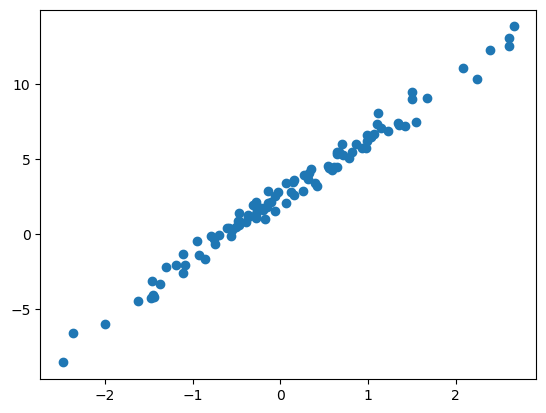

In [4]:
plt.plot(x,y,'o')

`(1)` `torch.nn.Linear`를 이용하여 아래와 같은 최초의 직선을 생성하는
네트워크를 설계하라. – 1점

$$\hat{y}_i = -5.0 + 10.0 x_i $$

In [15]:
net = torch.nn.Linear(1, 1, bias = True)
net.weight.data = torch.tensor([[10.0]])
net.bias.data = torch.tensor([-5.0])

`(2)` 아래의 수식에 대응하는 `loss`를 계산하라. 여기에서 $\hat{y}_i$은
(1)의 결과로 얻은 값을 사용하라. – 1점

$$loss = \frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2$$

In [16]:
yhat = net(x)

loss_fn = torch.nn.MSELoss()
loss1 = loss_fn(yhat, y)

print(f"loss = {loss1:.4f}")

loss = 85.8769


`(3)` 적당한 matrix ${\bf X}_{n\times 2}$ 와 $\hat{\bf W}_{2\times 1}$
을 정의하여 아래와 같이 $\hat{y}_i$을 구하라. – 1점

$$\hat{y}_i = -5.0 + 5.0 x_i $$

In [17]:
X = torch.concat([torch.ones(100, 1), x], axis = 1)
What = torch.tensor([[-5.0],
                     [5.0]], requires_grad = True)

yhat = X@What

`(4)` 아래의 수식에 대응하는 `loss`를 계산하라. 여기에서 $\hat{y}_i$은
(3)의 결과로 얻은 값을 사용하라. – 1점

$$loss = \frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2$$

In [18]:
loss2 = loss_fn(yhat, y)

print(f"loss = {loss2:.4f}")

loss = 55.0216


`(5)` (2)에서 얻은 $\hat{y}_i$ (4)에서 얻은 $\hat{y}_i$ 중 무엇이 더
적절하다고 생각하는가? 이유는 무엇인가? 손실(=loss)에 근거하여 설명하라.
– 2점

> (4)에서 얻은 $\hat{y}_i$의 손실값이 더 작으므로, (2)보다 적절하다.

`(6)` `.backward()` 를 이용하여 (2)와 (4)에 해당하는 미분값을 계산하라.
학습률이 0.01인 경사하강법을 이용하여 (1),(3) 에 대응하는 가중치를
update 하라. – 4점

In [19]:
## 미분값 계산
loss1.backward()
loss2.backward()

## update
net.weight.data -= 0.01*net.weight.grad
net.bias.data -= 0.01*net.bias.grad

What.data -= 0.01*What.grad

In [20]:
print(f"(2)의 미분값 : {torch.stack([net.bias.grad, net.weight.grad.reshape(-1)], axis = 1)}")
print(f"(4)의 미분값 : {What.grad.reshape(1, -1)}")

(2)의 미분값 : tensor([[-13.4225,  11.8893]])
(4)의 미분값 : tensor([[-14.6478,   0.4528]])


# 4. 네트워크 설계 – 10점

아래는 mnist자료를 분류하는 네트워크의 예시이다. 그림에 대응하는
네트워크를 파이토치로 설계하라.

![](https://editor.analyticsvidhya.com/uploads/90650dnn2.jpeg)

-   그림에서 n1=6, n2=16, n3=120 으로 설정하고, 드랍아웃비율은 50%로
    설정하라.
-   인풋이미지의 차원은 (28,28,1) 이 아니라 (n,1,28,28) 로 해석하라.
    동일한 논리로 Conv1의 통과결과도 (n,n1,24,24) 로 해석하라.
-   valid padding 의 의미는 padding 을 하지 않는다는 의미이다.

In [33]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 6, kernel_size = 5),
    torch.nn.MaxPool2d(kernel_size = 2), ## stride default : kernel_size
    torch.nn.Conv2d(6, 16, kernel_size = 5),
    torch.nn.MaxPool2d(kernel_size = 2),
    torch.nn.Flatten(),
    torch.nn.Linear(256, 120),
    torch.nn.ReLU(),
    torch.nn.Linear(120, 10),
    torch.nn.Dropout() ## ??? 이건 뭔 멍청한 신경망임? 왜 기껏 얻은 아웃풋을...
)

In [34]:
x = torch.randn(1, 1, 28, 28)
net(x)

tensor([[0.1165, 0.0997, 0.0997, 0.0997, 0.0831, 0.0997, 0.0997, 0.0999, 0.1147,
         0.0871]], grad_fn=<SoftmaxBackward0>)

# 5. 신경망의 학습 – 10점

아래를 이용하여 데이터를 불러오라.

In [25]:
x = torch.linspace(-1,1,2000).reshape(2000,1)
u = -1 + 5*x
v = torch.exp(u) / (1+torch.exp(u)) 
y = torch.bernoulli(v)

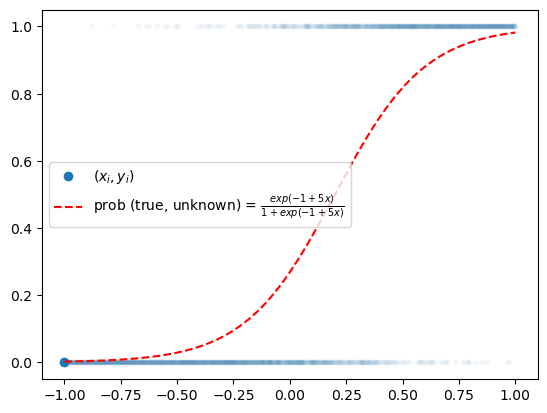

In [26]:
plt.plot(x,y,'.',alpha=0.03)
plt.plot(x[0],y[0],'o',label=r"$(x_i,y_i)$",color="C0")
plt.plot(x,v,'--r',label=r"prob (true, unknown) = $\frac{exp(-1+5x)}{1+exp(-1+5x)}$")
plt.legend()

`(1)` `torch.utils.data.TensorDataset`, `torch.utils.data.DataLoader` 를
이용하여 아래의 세부지침을 따르는 적당한 dataloader를 만들라. – 2점

**세부지침**

1.  `batch_size = 128` 로 설정할 것
2.  `shuffle = False` 로 설정할 것

In [27]:
ds = torch.utils.data.TensorDataset(x, y)
dl = torch.utils.data.DataLoader(ds, batch_size = 128, shuffle = False)

`(2)` 주어진 자료를 해석할 수 있는 적절한 `net` 및 손실함수를 설정하고
아래의 세부지침에 맞추어 학습하라. – 8점

**세부지침**

1.  30 epochs 학습
2.  GPU를 이용하여 학습 할 것
3.  옵티마이저로 `torch.optim.Adam`을 사용하고 학습률은 0.05로 설정할 것

> 언더라잉이 로지스틱 회귀모형이므로, 로지스틱 모형을 구성한다.

In [28]:
net = torch.nn.Sequential(
    torch.nn.Linear(1, 1, bias = True),
    torch.nn.Sigmoid()
).to("cuda:0")

loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters(), lr = 0.05)

##---##
for epoc in range(30) :
    for Xm, ym in dl :
        Xm = Xm.to("cuda:0")
        ym = ym.to("cuda:0")
        yhat = net(Xm)
        loss = loss_fn(yhat, ym)
        loss.backward()
        optimizr.step()
        optimizr.zero_grad()

In [34]:
net.to("cpu")

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): Sigmoid()
)

In [35]:
print(f"train acc = {((net(x) > 0.5) == y).float().mean():.4f}")

train acc = 0.8645
